# Western Monarch Butterfly Overwintering Analysis

## Overview
This notebook provides an analysis of Western Monarch butterfly overwintering data using statistics and machine learning techniques. We analyze three distinct datasets:

- **Sites Dataset**: Geographic and site characteristics
- **Counts Dataset**: Butterfly observation counts over time
- **Joined Dataset**: Combined sites and counts for comprehensive analysis



In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [2]:
# Utility Functions
def print_heading(heading):
    print("\n" + "="*60)
    print(heading)
    print("="*60)

# Function to print brief info for the given DataFrame object and column
def print_col_info(df, col):
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True, sort=True, ascending=False))
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most frequent: {df[col].mode()}\n")

## Data Analysis and Machine Learning

#### Load Sites and Counts Datasets

In [3]:
sites_df = pd.read_csv('data/sites_2025.csv')
counts_df = pd.read_csv('data/counts_2025.csv')

In [4]:
# Dataset dimensions
print_heading("Dataset Overview")
print(f"Sites dataset: {sites_df.shape[0]:,} rows × {sites_df.shape[1]} columns")
print(f"Counts dataset: {counts_df.shape[0]:,} rows × {counts_df.shape[1]} columns")

print("\nSites Info")
print("="*20)
print(sites_df.info())

print("\n\nCounts Info")
print("="*20)
print(counts_df.info())

print("\n\nSites Describe")
print("="*20)
print(sites_df.describe())
print("\n\nCounts Describe")
print("="*20)
print(counts_df.describe())
print("="*20)


Dataset Overview
Sites dataset: 526 rows × 11 columns
Counts dataset: 11,175 rows × 34 columns

Sites Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          526 non-null    int64  
 1   GlobalID          526 non-null    object 
 2   SiteID            526 non-null    int64  
 3   Region            526 non-null    object 
 4   Region ID         526 non-null    object 
 5   Site Status       525 non-null    object 
 6   CNDDB EO          320 non-null    float64
 7   Boundary Quality  524 non-null    object 
 8   WMC Site          522 non-null    object 
 9   Latitude          510 non-null    float64
 10  Longitude         510 non-null    float64
dtypes: float64(3), int64(2), object(6)
memory usage: 45.3+ KB
None


Counts Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175 entries, 0 to 11174
Data columns (tota

### Understanding the Data and its Features

#### Data Cleaning and Quality Assement

In [5]:
def display_missing_values(df, name): 
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(1)
    missing_summary = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_pct
    })
    # missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
    missing_summary = missing_summary.sort_values('Missing_Percent', ascending=False)
    #missing_summary = missing_summary[missing_summary['Missing_Percent'] < 66]

    print(f"Missing values in {missing_summary.shape[0]} columns:")
    # print(missing_summary.head(10))
    print(f"Missing values: {missing_summary.sort_values('Missing_Percent', ascending=True)}")


    # Data types summary
    print(f"\nData types: {df.dtypes.value_counts().to_dict()}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nKey numeric columns ({len(numeric_cols)} total):")
        for col in numeric_cols[:5]:
            valid_data = df[col].dropna()
            if len(valid_data) > 0:
                print(f"  {col}: {valid_data.min():.1f} - {valid_data.max():.1f} (mean: {valid_data.mean():.1f})")

    return missing_summary

##### Missing Values -- Sites Dataset

In [6]:
print_heading("Data Quality Assessment -- Sites Dataset")
sites_quality = display_missing_values(sites_df, 'Sites')


Data Quality Assessment -- Sites Dataset
Missing values in 11 columns:
Missing values:                   Missing_Count  Missing_Percent
OBJECTID                      0              0.0
GlobalID                      0              0.0
SiteID                        0              0.0
Region                        0              0.0
Region ID                     0              0.0
Site Status                   1              0.2
Boundary Quality              2              0.4
WMC Site                      4              0.8
Latitude                     16              3.0
Longitude                    16              3.0
CNDDB EO                    206             39.2

Data types: {dtype('O'): 6, dtype('float64'): 3, dtype('int64'): 2}

Key numeric columns (5 total):
  OBJECTID: 1.0 - 4956.0 (mean: 295.6)
  SiteID: 2675.0 - 3297.0 (mean: 2994.4)
  CNDDB EO: 1.0 - 396.0 (mean: 172.8)
  Latitude: 31.7 - 39.8 (mean: 35.4)
  Longitude: -123.8 - -116.6 (mean: -120.4)


##### Missing Values -- Counts Dataset

In [7]:
print_heading("Data Quality Assessment -- Counts Dataset")
counts_quality = display_missing_values(counts_df, 'Counts')


Data Quality Assessment -- Counts Dataset
Missing values in 34 columns:
Missing values:                            Missing_Count  Missing_Percent
ObjectID                               0              0.0
GlobalID                               0              0.0
Source ID                              0              0.0
Observation ID                         0              0.0
Observation Date                      49              0.4
Site ID                               61              0.5
GRAND TOTAL                          510              4.6
Verbatim Observation Date           2968             26.6
Vetted Date                         3413             30.5
QC Pass                             5036             45.1
Count Start Time                    7480             66.9
Total Minutes                       7501             67.1
Count End Time                      7505             67.2
Temp F                              7528             67.4
Clusters                            7609 

In [8]:
categorical_columns = sites_df.drop(columns=['GlobalID', 'Region ID', 'OBJECTID', 'CNDDB EO']).select_dtypes(include=['object', 'category']).columns

unique_values = {}

for col in categorical_columns:
    unique_values[col] = sites_df[col].unique()

print(categorical_columns)
print(unique_values)

Index(['Region', 'Site Status', 'Boundary Quality', 'WMC Site'], dtype='object')
{'Region': array(['San Diego', 'Los Angeles', 'Monterey', 'Alameda', 'Contra Costa',
       'Orange', 'Santa Barbara', 'Baja California', 'Mendocino',
       'Sonoma', 'Solano', 'San Francisco', 'San Mateo', 'Santa Cruz',
       'San Luis Obispo', 'Marin', 'Kern', 'Inyo', 'Ventura',
       'Santa Clara', 'Phoenix, AZ', 'Tempe, AZ', 'Lake Havasu, AZ',
       'Scottsdale, AZ', 'Parker, AZ'], dtype=object), 'Site Status': array(['Active', 'Historic Potential', 'Historic', 'Potential', nan],
      dtype=object), 'Boundary Quality': array(['High Information Boundary', 'Low Information Boundary',
       'Unreviewed Boundary', nan], dtype=object), 'WMC Site': array(['Yes', 'No', nan], dtype=object)}


In [9]:
id_cols = ['GlobalID', 'Tag ID', 'ObjectID', 'Observation ID', 'Vetted Date']
date_cols = ['Verbatim Observation Date', 'Observation Date', 'Count Start Time', 'Count End Time']
misc_cols = ['New Site', 'Site Access', 'Access Note', 'Weather Comments', 'Cluster Notes']
categorical_columns = counts_df.drop(columns=id_cols + date_cols + misc_cols).select_dtypes(include=['object', 'category']).columns

unique_values = {}

for col in categorical_columns:
    unique_values[col] = counts_df[col].unique()

print(categorical_columns)
print(unique_values)

Index(['Precipitation Type', 'Wind Direction', 'QC Pass'], dtype='object')
{'Precipitation Type': array([nan, 'Drizzle/Mist', 'Rain'], dtype=object), 'Wind Direction': array(['N', 'NE', nan, 'SW', 'WNW', 'S', 'ENE', 'NW', 'E', 'SE', 'SSE',
       'W', 'NNW', 'WSW', 'SW,W', 'NW,E', 'E,NE', 'NE,W,NW', 'NE,SW',
       'S,SW', 'NW,N', 'N,NE', 'S,SE', 'SE,S', 'SE,E', 'N,NW', 'NE,E',
       'E,SE', 'SW,S', 'S,SE,SW', 'S,SE,SW,W', 'SSW', 'ESE', 'NNE', 'W\t',
       'NW,SE', 'NE,NW', 'S,N,E', 'NW,W', 'NE,N', 'W,None', 'SE,None',
       'None,SW', 'None,SE', 'None,E', 'N,NE,NW', 'None,NW', 'None,NE',
       'SW,None', 'W,NW,N', 'N,None', 'W,SW', 'N,NE,NW,S,SW,W', 'NE,None',
       'NW,None', 'SW,E', 'E,None', 'None,N', 'N,NW,None', 'N,SE',
       'S,None', 'None,W', 'NW,NE', 'N,W,SE,NE,S,E,NW,SW', 'W,NW'],
      dtype=object), 'QC Pass': array([nan, 'Yes'], dtype=object)}


In [10]:
print_heading("Target Variable Analysis -- GRAND TOTAL")

grand_total = counts_df['GRAND TOTAL'].dropna()

print(counts_df['GRAND TOTAL'].describe())

# Distribution analysis
print(f"\nDistribution Analysis:")
print(f"Zero counts: {(grand_total == 0).sum():,} ({(grand_total == 0).mean()*100:.1f}%)")
print(f"Low counts (1-10): {((grand_total > 0) & (grand_total <= 10)).sum():,}")
print(f"Medium counts (11-100): {((grand_total > 10) & (grand_total <= 100)).sum():,}")
print(f"High counts (101-1000): {((grand_total > 100) & (grand_total <= 1000)).sum():,}")
print(f"Very high counts (>1000): {(grand_total > 1000).sum():,}")




Target Variable Analysis -- GRAND TOTAL
count     10665.000000
mean       1624.317768
std        7183.458858
min           0.000000
25%           0.000000
50%           6.000000
75%         280.000000
max      200000.000000
Name: GRAND TOTAL, dtype: float64

Distribution Analysis:
Zero counts: 3,877 (36.4%)
Low counts (1-10): 2,004
Medium counts (11-100): 1,583
High counts (101-1000): 1,412
Very high counts (>1000): 1,789


## Visualization of target distriution

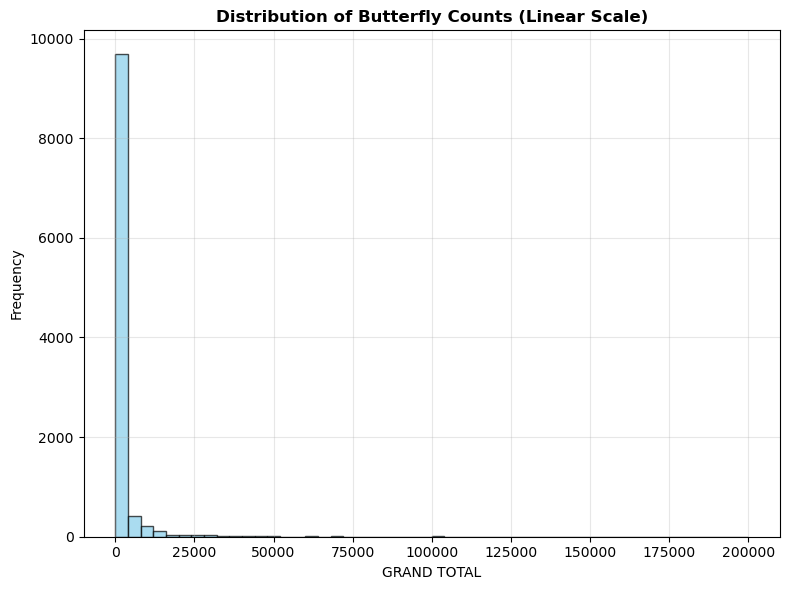

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(grand_total, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Butterfly Counts (Linear Scale)', fontweight='bold')
plt.xlabel('GRAND TOTAL')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

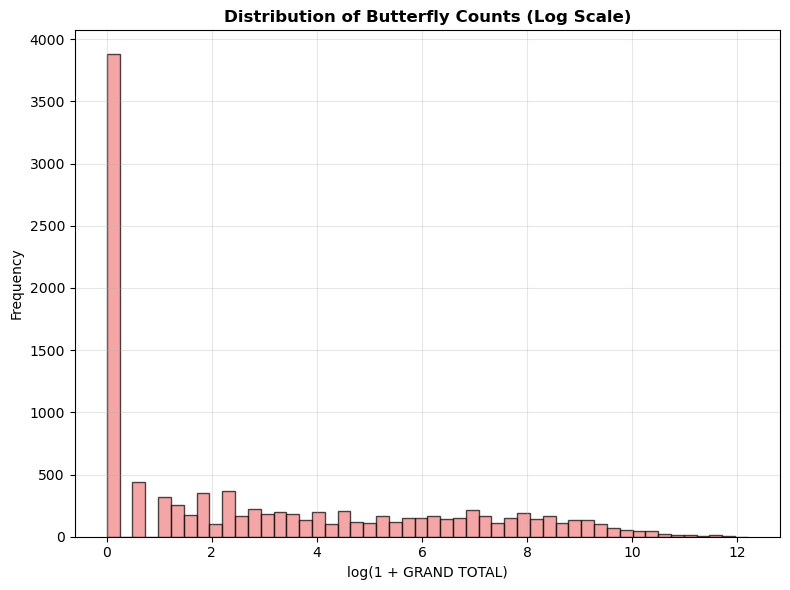

In [12]:
# Log-scale histogram
log_counts = np.log1p(grand_total)

plt.figure(figsize=(8, 6))
plt.hist(log_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Butterfly Counts (Log Scale)', fontweight='bold')
plt.xlabel('log(1 + GRAND TOTAL)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

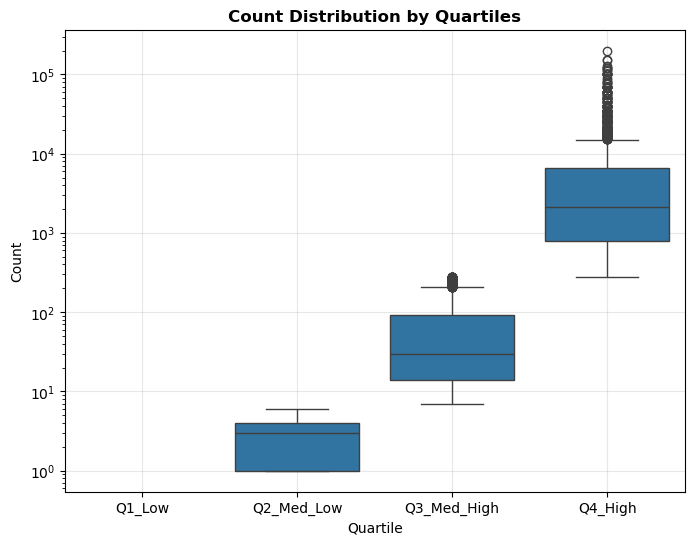

In [13]:
# Boxplot by quantiles
quantiles = grand_total.quantile([0.25, 0.5, 0.75]).values
count_quartiles = pd.cut(grand_total, 
                        bins=[-np.inf] + list(quantiles) + [np.inf],
                        labels=['Q1_Low', 'Q2_Med_Low', 'Q3_Med_High', 'Q4_High'])

quartile_data = pd.DataFrame({'Count': grand_total, 'Quartile': count_quartiles})

plt.figure(figsize=(8,6))
sns.boxplot(data=quartile_data, x='Quartile', y='Count')
plt.title('Count Distribution by Quartiles', fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

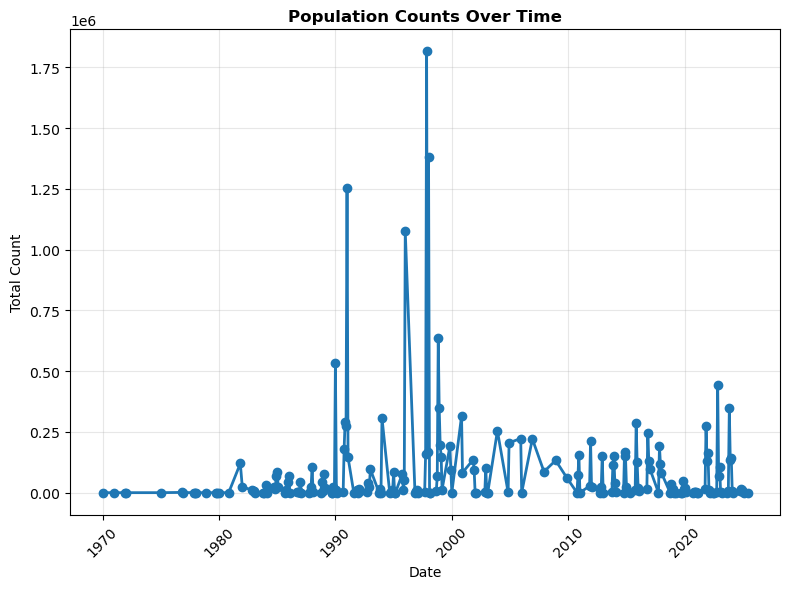

In [14]:
# Time series plot
counts_df['Observation Date'] = pd.to_datetime(counts_df['Observation Date'], errors='coerce')
monthly_totals = counts_df.groupby(counts_df['Observation Date'].dt.to_period('M'))['GRAND TOTAL'].sum()

plt.figure(figsize=(8,6))
plt.plot(monthly_totals.index.to_timestamp(), monthly_totals.values, marker='o', linewidth=2)
plt.title('Population Counts Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Count')
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

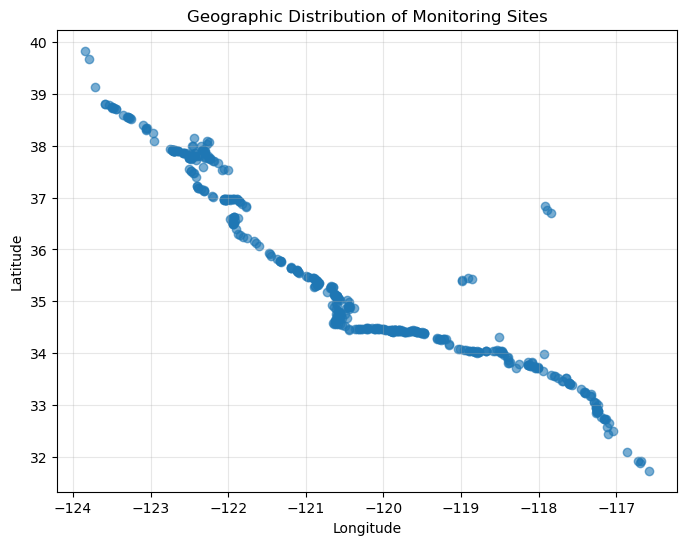

In [15]:
# Plot geographic distribution
plt.figure(figsize=(8, 6))
plt.scatter(sites_df['Longitude'], sites_df['Latitude'], alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Monitoring Sites')
plt.grid(True, alpha=0.3)
plt.show()

### Feature Engineering and Data Preparation

In [16]:
print_heading("Preprocessing Sites Dataset")
#print(sites_processed.columns)

sites_processed = sites_df.copy()

# Handle missing values
sites_processed = sites_processed.dropna(subset=['Latitude', 'Longitude'])

# Create geographic regions based on latitude
sites_processed['Region'] = pd.cut(sites_processed['Latitude'], 
                                    bins=3, 
                                    labels=['Southern', 'Central', 'Northern'])

print("Preprocessing Sites datasets...")
#print(f"Columns in sites ML dataset: {sites_processed.columns}")
print(f"Sites processed shape: {sites_processed.shape}")



Preprocessing Sites Dataset
Preprocessing Sites datasets...
Sites processed shape: (510, 11)


In [17]:
print("Preprocessing Counts datasets...")
counts_processed = counts_df.copy()

date_cols = [col for col in counts_processed.columns if 'date' in col.lower() or 'Date' in col]
#print(f"Date cols: {date_cols}")
for col in date_cols:
    counts_processed[col] = pd.to_datetime(counts_processed[col], errors='coerce')

count_col = "GRAND TOTAL"   
counts_processed[count_col] = pd.to_numeric(counts_processed[count_col], errors='coerce')
counts_processed[count_col] = counts_processed[count_col].fillna(0)

counts_processed['log_count'] = np.log1p(counts_processed[count_col]) 

# quantile-based binning
quantiles = counts_processed[count_col].quantile([0.25, 0.5, 0.75]).values
print(f"quantiles: {[-np.inf] + list(quantiles) + [np.inf]}\n")
counts_processed['count_quartile'] = pd.cut(counts_processed[count_col], 
                                bins=[-np.inf] + list(quantiles) + [np.inf],
                                labels=['Q1_Low', 'Q2_Medium_Low', 'Q3_Medium_High', 'Q4_High'])

median_count = counts_processed[count_col].median()
counts_processed['high_count'] = (counts_processed[count_col] > median_count).astype(int)
counts_processed['has_count'] = (counts_processed[count_col] > 0).astype(int)
    
# Create categories with explicit handling of edge cases
counts_processed['Count_Category'] = pd.cut(counts_processed[count_col], 
                                    bins=[-0.1, 10, 100, 1000, float('inf')], 
                                    labels=['Very_Low', 'Low', 'Medium', 'High'],
                                    include_lowest=True)

counts_processed = counts_processed.dropna(subset=['Count_Category'])
print(counts_processed['Count_Category'].value_counts())

# print(f"Columns in counts ML dataset: {counts_processed.columns}")
print(f"\nCounts processed shape: {counts_processed.shape}")
#counts_processed.info()

Preprocessing Counts datasets...
quantiles: [-inf, 0.0, 5.0, 215.0, inf]

Count_Category
Very_Low    6391
High        1789
Low         1583
Medium      1412
Name: count, dtype: int64

Counts processed shape: (11175, 39)


In [18]:
# ML-Ready Sites datasets
ml_sites_df = sites_processed.copy()

feature_cols = []
feature_cols.append('Latitude')
feature_cols.append('Longitude')

# Encode categorical features
le = LabelEncoder()
if 'Region' in ml_sites_df.columns:
    ml_sites_df['Region_Encoded'] = le.fit_transform(ml_sites_df['Region'].astype(str))
    feature_cols.append('Region_Encoded')

if 'Site_Type' in ml_sites_df.columns:
    ml_sites_df['Site_Type_Encoded'] = le.fit_transform(ml_sites_df['Site_Type'].astype(str))
    feature_cols.append('Site_Type_Encoded')

# Create target variable (site activity level based on geographic clustering)
if 'Latitude' in ml_sites_df.columns and 'Longitude' in ml_sites_df.columns:
    coords = ml_sites_df[['Latitude', 'Longitude']].values
    kmeans = KMeans(n_clusters=3, random_state=42)
    ml_sites_df['Activity_Level'] = kmeans.fit_predict(coords)

X_sites = ml_sites_df[feature_cols]
y_sites = ml_sites_df['Activity_Level']

print(f"Sites ML dataset: {X_sites.shape if X_sites is not None else 'None'}")
print(f"Columns in sites ML dataset: {X_sites.columns}")

Sites ML dataset: (510, 3)
Columns in sites ML dataset: Index(['Latitude', 'Longitude', 'Region_Encoded'], dtype='object')


In [19]:
# ML-Ready Counts datasets
ml_sites_df = counts_processed.copy()

feature_cols = []
# date_cols = [col for col in ml_sites_df.columns if 'date' in col.lower() or 'Date' in col]
#print(f"date_cols: {date_cols}")

if date_cols:
    date_col = "Observation Date"
    ml_sites_df['Year'] = ml_sites_df[date_col].dt.year
    ml_sites_df['Month'] = ml_sites_df[date_col].dt.month
    ml_sites_df['DayOfYear'] = ml_sites_df[date_col].dt.dayofyear
    feature_cols.extend(['Year', 'Month', 'DayOfYear'])

# Add "Log_Count"
ml_sites_df['Log_Count'] = np.log1p(ml_sites_df["GRAND TOTAL"])
feature_cols.append('Log_Count')

target = ml_sites_df['Count_Category']

X_counts = ml_sites_df[feature_cols]
y_counts = target

print(f"Counts ML dataset: {X_counts.shape if X_counts is not None else 'None'}")
print(f"Columns in sites ML dataset: {X_counts.columns}")


Counts ML dataset: (11175, 4)
Columns in sites ML dataset: Index(['Year', 'Month', 'DayOfYear', 'Log_Count'], dtype='object')


In [20]:
joined_df = pd.merge(sites_df, counts_df,
                    left_on='SiteID',
                    right_on='Site ID',
                    how='inner')
                                                       
feature_cols = []

# Geographic features
feature_cols.append('Latitude')
feature_cols.append('Longitude')

# Add "Log_Count"
count_col = "GRAND TOTAL"
joined_df['Log_Count'] = np.log1p(joined_df[count_col])
feature_cols.append('Log_Count')

# Temporal features
date_col = "Observation Date"
joined_df[date_col] = pd.to_datetime(joined_df[date_col], errors='coerce')
joined_df['Month'] = joined_df[date_col].dt.month
feature_cols.append('Month')

# Target variable: high vs low activity sites
median_count = joined_df[count_col].median()
joined_df['High_Activity'] = (joined_df[count_col] > median_count).astype(int)

X_joined = joined_df[feature_cols]
y_joined = joined_df['High_Activity']

print(f"\nJoined ML dataset: {X_joined.shape if X_joined is not None else 'None'}")
print(f"Columns in joined ML dataset: {X_joined.columns}")


Joined ML dataset: (10954, 4)
Columns in joined ML dataset: Index(['Latitude', 'Longitude', 'Log_Count', 'Month'], dtype='object')


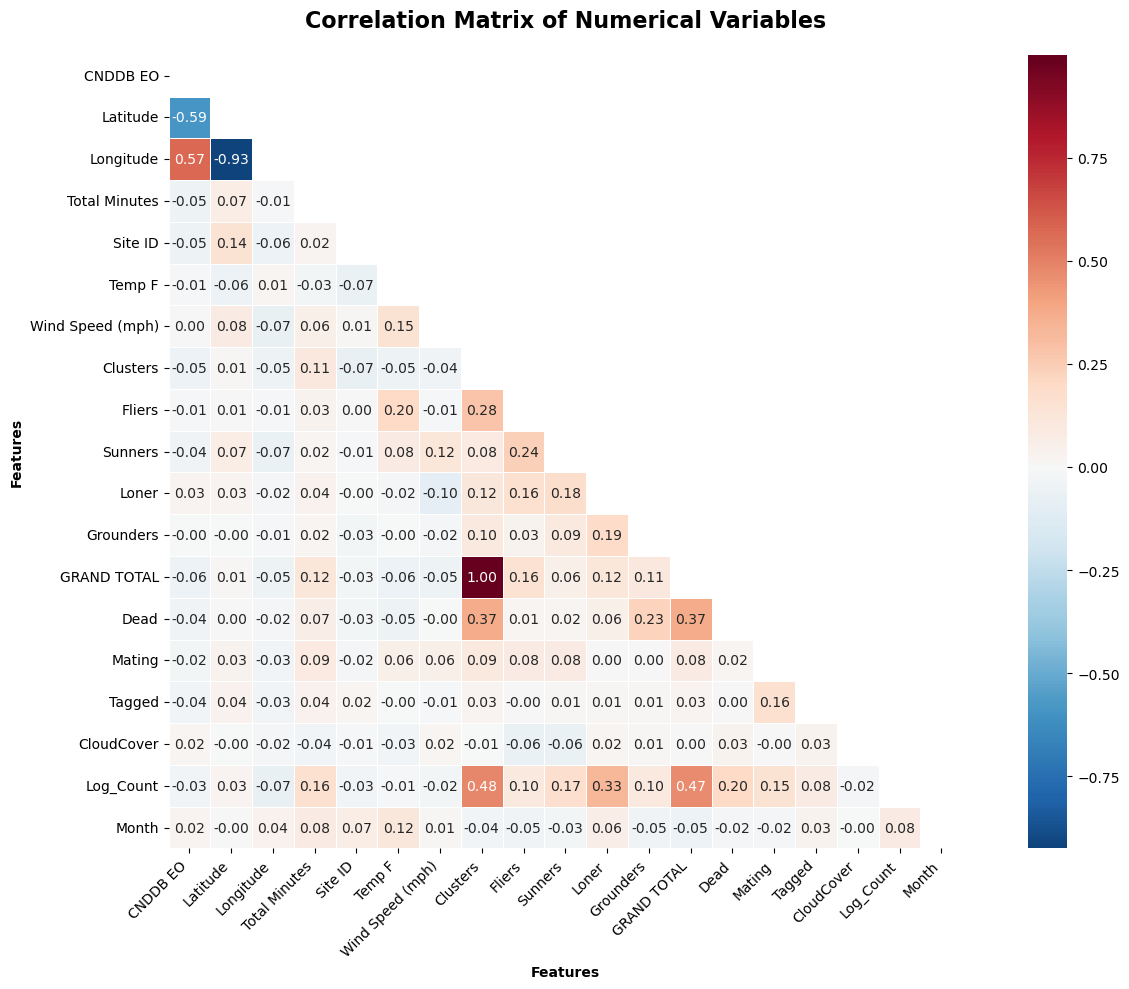

In [21]:
# Correlation Analysis
#numerical_cols = joined_df.drop('High_Activity', axis=1).select_dtypes(include=[np.number]).columns.tolist()

numerical_cols = ['CNDDB EO','Latitude','Longitude','Total Minutes','Site ID','Temp F','Wind Speed (mph)','Clusters',
                  'Fliers','Sunners','Loner','Grounders','GRAND TOTAL','Dead','Mating','Tagged','CloudCover','Log_Count','Month']
numerical_data = joined_df[numerical_cols]
correlation_matrix = numerical_data.corr()

# heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
                      center=0, square=True, fmt='.2f', 
                      linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Analyze Class Distribution

Sites Dataset Analysis
Number of unique classes: 3
Class distribution:
Activity_Level
2    234
0    164
1    112
Name: count, dtype: int64


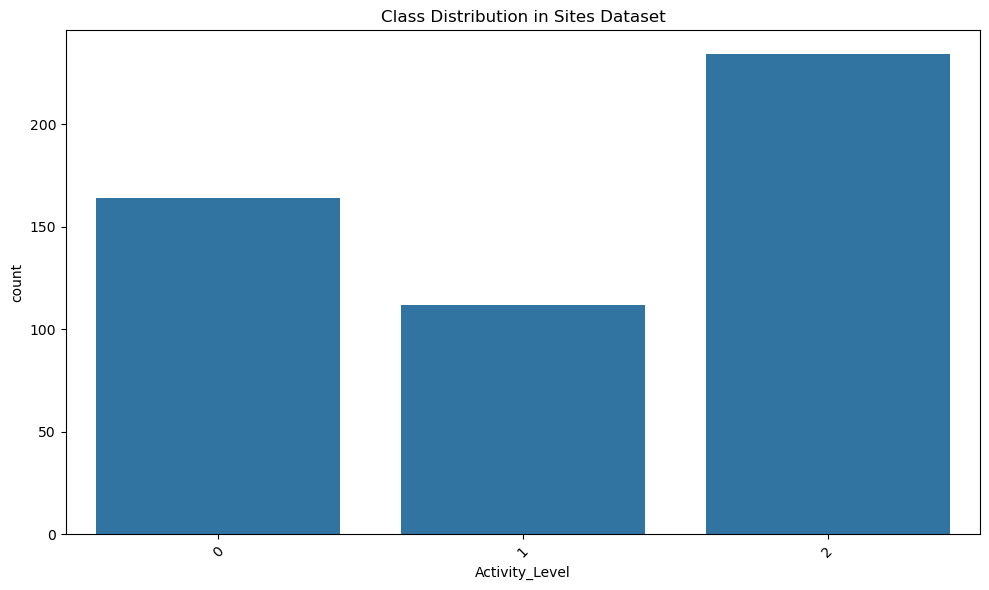


Counts Dataset Analysis
Number of unique classes: 4
Class distribution:
Count_Category
Very_Low    6391
High        1789
Low         1583
Medium      1412
Name: count, dtype: int64


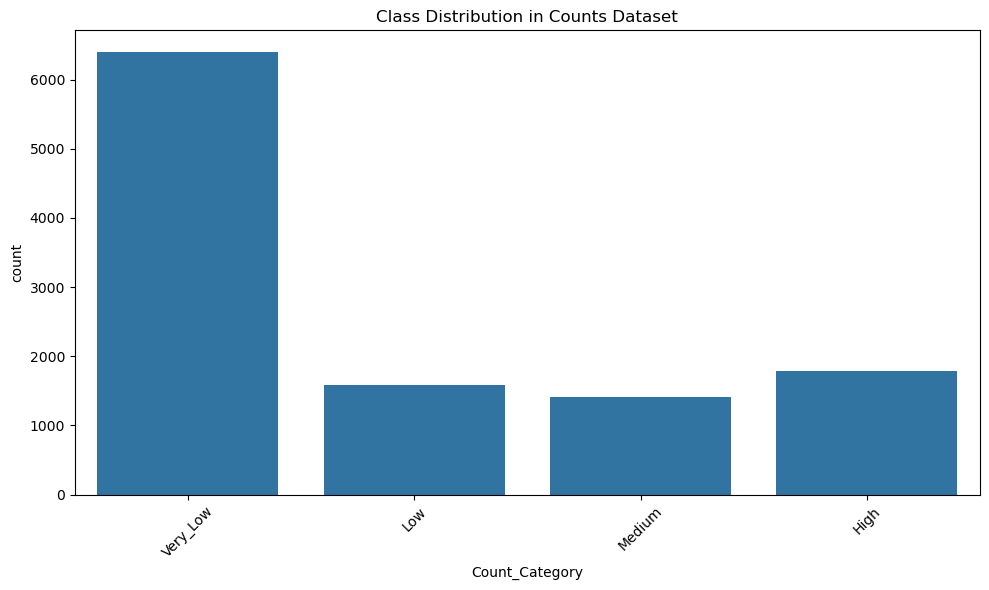


Joined Dataset Analysis
Number of unique classes: 2
Class distribution:
High_Activity
0    5747
1    5207
Name: count, dtype: int64


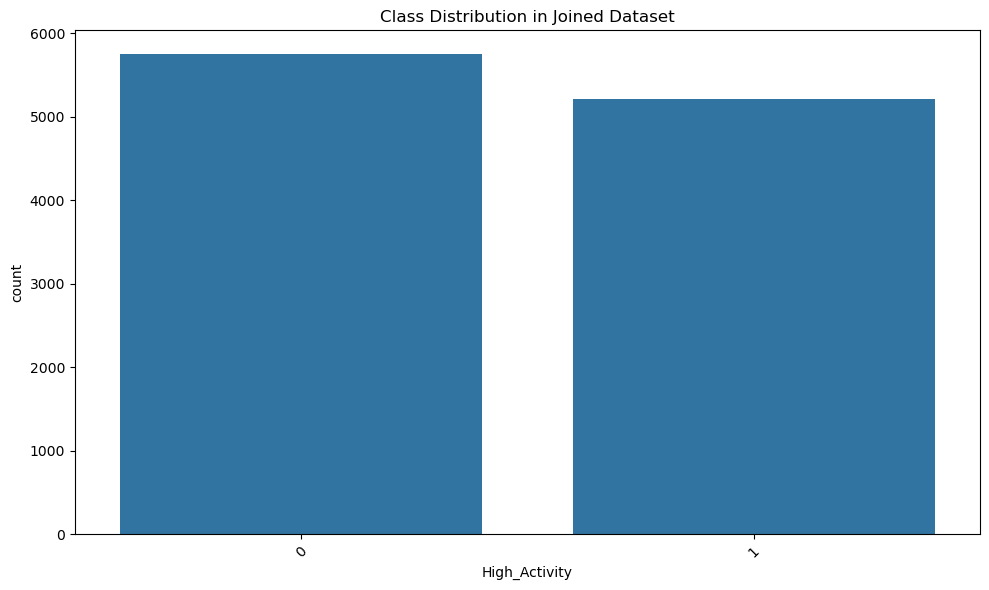

Sites dataset: 510 samples, 3 features
Counts dataset: 11175 samples, 4 features
Joined dataset: 10954 samples, 4 features


In [22]:
print_heading("Analyze Class Distribution")

def analyze_class_distribution(X, y, dataset_name):
    """ Plots unique classes and their counts """
    print(f"\n{dataset_name} Dataset Analysis")
    print("="*60)
    
    unique_classes = np.unique(y)
    class_counts = pd.Series(y).value_counts()
    
    print(f"Number of unique classes: {len(unique_classes)}")
    print(f"Class distribution:\n{class_counts}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_class_distribution(X_sites, y_sites, 'Sites')
analyze_class_distribution(X_counts, y_counts, 'Counts')
analyze_class_distribution(X_joined, y_joined, 'Joined')

# Check sample sizes
print(f"Sites dataset: {X_sites.shape[0]} samples, {X_sites.shape[1]} features")
print(f"Counts dataset: {X_counts.shape[0]} samples, {X_counts.shape[1]} features")
print(f"Joined dataset: {X_joined.shape[0]} samples, {X_joined.shape[1]} features")

## Train and Evaluate Models


In [40]:
categorical_features = ['Month']
numeric_features = ['Latitude', 'Longitude', 'Log_Count']

X = X_joined.copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"\nMissing values:\n{X.isnull().sum()}")

Feature matrix shape: (10954, 4)
Features: ['Latitude', 'Longitude', 'Log_Count', 'Month']

Missing values:
Latitude      26
Longitude     26
Log_Count    473
Month         32
dtype: int64


In [41]:
# Create preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Preprocessing pipeline created successfully!")

Preprocessing pipeline created successfully!
